In [94]:
# JAX's syntax is (for the most part) same as NumPy's!
import jax.numpy as jnp
import numpy as np
import jax

# Special transform functions (we'll understand what these are very soon!)
from jax import grad, jit, vmap, pmap

# JAX's low level API 
# (lax is just an anagram for XLA, not completely sure how they came up with name JAX)
from jax import lax

from jax import random
from jax import device_put
import matplotlib.pyplot as plt

import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

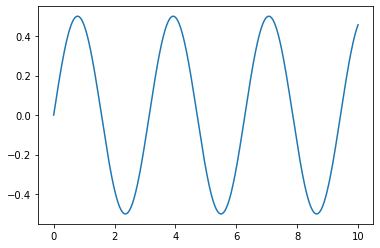

In [95]:
# Fact 1: JAX's syntax is remarkably similar to NumPy's 
x_np = np.linspace(0, 10, 1000)
y_np = np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

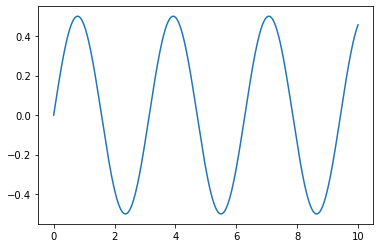

In [96]:
# Fact 1: JAX's syntax is remarkably similar to NumPy's 
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = np.sin(x_jnp) * np.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [97]:
# Fact 2: JAX arrays are immutable! (embrace the functional programming paradigm <3)

size = 10
index = 0
value = 23

# In NumPy arrays are mutable
x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [98]:
x = jnp.arange(size)
# print(x)
# x[index] = value
# print(x)

# Solution/workaround:
y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [99]:
# Fact 3: JAX handles random numbers differently
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))  # you need to explicitly pass the key i.e. PRNG state
print(type(x), x)  # notice the DeviceArray type - that leads us to the next cell!

<class 'jaxlib.xla_extension.DeviceArray'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [100]:
# Fact 4: JAX is AI accelerator agnostic. Same code runs everywhere!

size = 3000

# Data is automagically pushed to the AI accelerator! (DeviceArray structure)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# Note2: block_until_ready() -> asynchronous dispatch

1 loop, best of 5: 870 ms per loop
1 loop, best of 5: 438 ms per loop
1 loop, best of 5: 891 ms per loop
1 loop, best of 5: 894 ms per loop


### `grad()` 101

Differentation can be:
* manual
* symbolic
* numeric
* automatic! 

In [101]:
# First example (automatic diff)

def sum_logistic(x):  # or maybe a simpler example: sum of squares? (jnp.sum(x**2))
    # return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))
    return jnp.sum(x**3)


# x = jnp.arange(3.)
x = 2.
loss = sum_logistic  # rename it to give it some semantics

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.
grad_loss = grad(loss)

print(grad_loss(x))

12.0


In [102]:
def sum_of_squares(x):
  return jnp.sum(x**2)

sum_of_squares_dx = grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))  

30.0
[2. 4. 6. 8.]


In [103]:
def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0


0.4199743


In [104]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

grad(sum_squared_error, argnums=(0, 1))(x, y)  # Find gradient wrt both x & y

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

In [105]:
jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

In [106]:
# Second example (automatic diff)

x = 1.  # example input

f = lambda x: x**2 + x + 4  # simple 2nd order polynomial fn


dfdx = grad(f)  # 2*x + 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx)  # 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

6.0 3.0 2.0 0.0


### JAX API structure

In [107]:
# Example 1: lax is stricter

print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
print(lax.add(1, 1))  # jax.lax API requires explicit type promotion (Same DataTypes)

2.0
2


In [108]:
# Example 2: lax is more powerful (but as a tradeoff less user-friendly)

x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# NumPy API
result1 = jnp.convolve(x, y) #Returns the discrete, linear convolution of two one-dimensional sequences
result1

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

In [109]:
# Why JIT? -> jitted functions are much faster.

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(X), norm_compiled(X), atol=1E-6)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

100 loops, best of 5: 5.79 ms per loop
100 loops, best of 5: 4.74 ms per loop
